In [1]:
!git clone https://github.com/kmasta/Aiffel_DLThon.git

Cloning into 'Aiffel_DLThon'...
remote: Enumerating objects: 509, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 509 (delta 43), reused 42 (delta 26), pack-reused 420 (from 1)
Receiving objects: 100% (509/509), 80.87 MiB | 16.94 MiB/s, done.
Resolving deltas: 100% (241/241), done.
Updating files: 100% (196/196), done.


In [2]:
import transformers
print(transformers.__version__)

4.51.3


# Baseline Code

## 필요한 라이브러리 임포트

In [3]:
import yaml
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, ElectraForSequenceClassification
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import Dataset
import torch
import os

from Aiffel_DLThon.pytorch_code.callback.logger import log_message, log_target_distribution, LoggingCallback
from Aiffel_DLThon.pytorch_code.callback.early_stopping import EarlyStopping
from Aiffel_DLThon.pytorch_code.callback.checkpoint import save_model
from Aiffel_DLThon.pytorch_code.callback.save_results import save_submission

## 모델 정보 불러오기

In [4]:
# Load model name
with open("./Aiffel_DLThon/pytorch_code/config/model_name.yaml", "r") as f:
    model_name_config = yaml.safe_load(f)
model_key = model_name_config["model_name"]

# Load full config for that model
with open(f"./Aiffel_DLThon/pytorch_code/config/{model_key}.yaml", "r") as f:
    config = yaml.safe_load(f)

log_message(f"Running experiment: {config['experiment_name']}", config["log_dir"])

[2025-05-06 19:45:17] Running experiment: klue_roberta_exp3


## 토크나이저, 모델 구현

In [5]:
from transformers import ElectraPreTrainedModel, ElectraModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn.functional as F
import torch.nn as nn

class ElectraTwoStageModel(ElectraPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.electra = ElectraModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.stage1_classifier = nn.Linear(config.hidden_size, 2)  # Binary
        self.stage2_classifier = nn.Linear(config.hidden_size, 4)  # Multiclass

        self.init_weights()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None,
            binary_labels=None, multiclass_labels=None):
        outputs = self.electra(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        cls_output = self.dropout(outputs.last_hidden_state[:, 0, :])

        # Stage 1: 일반 vs 특수
        stage1_logits = self.stage1_classifier(cls_output)

        # Stage 2: 일반 중 세부 분류
        stage2_logits = self.stage2_classifier(cls_output)

        loss = None
        if binary_labels is not None and multiclass_labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss1 = loss_fct(stage1_logits, binary_labels)

            mask = (binary_labels == 0)
            if mask.sum() > 0:
                loss2 = loss_fct(stage2_logits[mask], multiclass_labels[mask])
                loss = loss1 + loss2
            else:
                loss = loss1

        return SequenceClassifierOutput(
            loss=loss,
            logits=stage1_logits
        )

In [6]:
from transformers import RobertaModel, RobertaPreTrainedModel

class RobertaTwoStageModel(RobertaPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.roberta           = RobertaModel(config)
        self.dropout           = nn.Dropout(config.hidden_dropout_prob)
        self.stage1_classifier = nn.Linear(config.hidden_size, 2)
        # Temperature Scaling 파라미터 (초기값 1.0)
        self.temperature = nn.Parameter(torch.ones(1))
        self.init_weights()

    def forward(self,
                input_ids,
                attention_mask=None,
                token_type_ids=None,
                labels=None,
                calibrate: bool = False):
        # 1) RoBERTa 통과
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        # 2) [CLS] 토큰 임베딩
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)

        # 3) Stage1 로짓
        logits = self.stage1_classifier(cls_output)  # (batch, 2)

        # 4) Temperature Scaling 적용
        #    - training 중에는 원본 logits 그대로
        #    - inference 또는 calibrate=True 경우 temperature로 나눔
        if not self.training or calibrate:
            # clamp로 0 방지
            T = self.temperature.clamp(min=1e-6)
            logits = logits / T

        # 5) Loss 계산 (label_smoothing=0.2)
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(label_smoothing=0.2)
            loss = loss_fn(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits
        )

    @torch.no_grad()
    def calibrate_temperature(self, valid_loader, device, lr: float = 0.01, max_iter: int = 50):
        """
        검증셋(valid_loader)에 대해 temperature(T)만 최적화합니다.
        """
        self.to(device)
        self.eval()
        logits_list, labels_list = [], []
        for batch in valid_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            out = self.forward(**batch, calibrate=False)
            logits_list.append(out.logits)
            labels_list.append(batch['labels'])
        logits = torch.cat(logits_list, dim=0)
        labels = torch.cat(labels_list, dim=0)

        # T만 최적화
        optimizer = torch.optim.LBFGS([self.temperature], lr=lr, max_iter=max_iter)

        def _eval():
            optimizer.zero_grad()
            loss = F.cross_entropy(logits / self.temperature.clamp(min=1e-6), labels)
            loss.backward()
            return loss


In [7]:
tokenizer = AutoTokenizer.from_pretrained('klue/roberta-base')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/752k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

## 커스텀 데이터셋 클래스(토크나이징)

In [8]:
class TwoStageDataset(Dataset):
    def __init__(self, encodings, binary_labels, multiclass_labels):
        self.encodings = encodings
        self.binary_labels = binary_labels
        self.multiclass_labels = multiclass_labels

    def __len__(self):
        return len(self.binary_labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.binary_labels[idx])  # ✅ 반드시 Trainer용 key
        item["binary_labels"] = torch.tensor(self.binary_labels[idx])
        item["multiclass_labels"] = torch.tensor(self.multiclass_labels[idx])
        return item

In [9]:
class BinaryDataset(Dataset):
    def __init__(self, encodings, binary_labels):
        num = len(next(iter(encodings.values())))
        assert num == len(binary_labels), "encodings와 라벨 길이가 달라요"
        self.encodings     = encodings
        self.binary_labels = binary_labels

    def __len__(self):
        return len(self.binary_labels)

    def __getitem__(self, idx):
        item = {}
        for k, v in self.encodings.items():
            # 이미 Tensor이면 바로 슬라이스
            item[k] = v[idx] if isinstance(v, torch.Tensor) else torch.tensor(v[idx])
        item["labels"] = torch.tensor(self.binary_labels[idx])
        return item

class MultiDataset(Dataset):
    def __init__(self, encodings, multiclass_labels):
        num = len(next(iter(encodings.values())))
        assert num == len(multiclass_labels), "encodings와 라벨 길이가 달라요"
        self.encodings         = encodings
        self.multiclass_labels = multiclass_labels

    def __len__(self):
        return len(self.multiclass_labels)

    def __getitem__(self, idx):
        item = {}
        for k, v in self.encodings.items():
            item[k] = v[idx] if isinstance(v, torch.Tensor) else torch.tensor(v[idx])
        item["labels"] = torch.tensor(self.multiclass_labels[idx])
        return item

## 데이터 불러오기

In [10]:
from sklearn.model_selection import train_test_split

def prepare_two_stage_dataset(texts, labels, tokenizer, max_length=400, test_size=0.2):
    # 1) Stage1 이진 레이블, Stage2 다중 레이블(-1은 일반 대화)
    binary_labels    = [0 if l in [0,1,2,3] else 1 for l in labels]
    multiclass_labels= [l if l in [0,1,2,3] else -1 for l in labels]

    # 2) Train/Val 분리 (stratify는 원래 multiclass_labels가 아니라 binary_labels 로 하는 게 안전합니다)
    train_texts, val_texts, \
    train_binary, val_binary, \
    train_multi,  val_multi = train_test_split(
        texts, binary_labels, multiclass_labels,
        test_size=test_size,
        stratify=binary_labels,  # 일반/협박 비율 유지
        random_state=42
    )

    # 3) 토크나이즈
    train_enc = tokenizer(train_texts, truncation=True, padding=True,
                           max_length=max_length, return_tensors="pt")
    val_enc   = tokenizer(val_texts,   truncation=True, padding=True,
                           max_length=max_length, return_tensors="pt")

    # 4) Stage1 Dataset
    binary_train_dataset = BinaryDataset(train_enc, train_binary)
    binary_val_dataset   = BinaryDataset(val_enc,   val_binary)

    # 5) Stage2: multiclass_labels == -1 인 인덱스 제거
    train_idx_keep = [i for i, l in enumerate(train_multi) if l != -1]
    val_idx_keep   = [i for i, l in enumerate(val_multi)   if l != -1]

    # 텐서 슬라이싱: 각 key에 대해 first-dim 인덱싱
    def slice_enc(encodings, idxs):
        return {k: v[idxs] for k, v in encodings.items()}

    train_enc_filt = slice_enc(train_enc, train_idx_keep)
    val_enc_filt   = slice_enc(val_enc,   val_idx_keep)

    train_multi_filt = [train_multi[i] for i in train_idx_keep]
    val_multi_filt   = [val_multi[i]   for i in val_idx_keep]

    multi_train_dataset = MultiDataset(train_enc_filt, train_multi_filt)
    multi_val_dataset   = MultiDataset(val_enc_filt,   val_multi_filt)

    return binary_train_dataset, multi_train_dataset, binary_val_dataset, multi_val_dataset

In [11]:
train_df = pd.read_csv("./Aiffel_DLThon/data/processed/stopwords/original/st_train.csv")
texts = train_df["clean_text"].tolist()
labels = train_df["label"].tolist()

gen1_df = pd.read_csv("./Aiffel_DLThon/data/processed/stopwords/generated/st_general.csv")
texts.extend(gen1_df["clean_text"].tolist())
labels.extend(gen1_df["label"].tolist())

gen_bad_df1 = pd.read_csv( "./Aiffel_DLThon/data/processed/stopwords/generated/st_bad.csv")
texts.extend(gen_bad_df1["clean_text"].tolist())
labels.extend(gen_bad_df1["label"].tolist())

gen_bad_df2 = pd.read_csv( "./Aiffel_DLThon/data/processed/stopwords/generated/st_bad2.csv")
texts.extend(gen_bad_df2["clean_text"].tolist())
labels.extend(gen_bad_df2["label"].tolist())

back_trans_df = pd.read_csv("./Aiffel_DLThon/data/processed/stopwords/augmented/st_backT.csv")
texts.extend(back_trans_df["clean_text"].tolist())
labels.extend(back_trans_df["label"].tolist())

ri_df = pd.read_csv("./Aiffel_DLThon/data/processed/stopwords/augmented/st_ri.csv")
texts.extend(ri_df["clean_text"].tolist())
labels.extend(ri_df["label"].tolist())

#eda_df = pd.read_csv("./Aiffel_DLThon/data/processed/stopwords/augmented/st_eda.csv")
#texts.extend(eda_df["clean_text"].tolist())
#labels.extend(eda_df["label"].tolist())
#gen2_df = pd.read_csv("./Aiffel_DLThon/data/processed/stopwords/generated/st_general2.csv")
#texts.extend(gen2_df["clean_text"].tolist())
#labels.extend(gen2_df["label"].tolist())
#rd_df = pd.read_csv("./Aiffel_DLThon/data/processed/stopwords/augmented/st_rd.csv")
#texts.extend(rd_df["clean_text"].tolist())
#labels.extend(rd_df["label"].tolist())
#mlm_df = pd.read_csv('./Aiffel_DLThon/data/processed/augmented/clean_mlm.csv')
#texts.extend(mlm_df["clean_text"].tolist())
#labels.extend(mlm_df["label"].tolist())

In [12]:
data_df = pd.concat([train_df, gen1_df, gen_bad_df1, gen_bad_df2, back_trans_df, ri_df], ignore_index=True)

In [13]:
binary_train_dataset, multi_train_dataset, binary_val_dataset, multi_val_dataset = prepare_two_stage_dataset(texts, labels, tokenizer)

In [14]:
sample = binary_val_dataset[0]
print("🔍 sample['labels']:", sample['labels'])
print("🔍 type:", type(sample['labels']))

🔍 sample['labels']: tensor(0)
🔍 type: <class 'torch.Tensor'>


In [15]:
label_counts = pd.Series(labels).value_counts().sort_index()

print("📊 train label 클래스 분포:")
print(label_counts)

📊 train label 클래스 분포:
0    2688
1    2943
2    2937
3    3282
4    3036
Name: count, dtype: int64


## 매트릭 함수

In [16]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
from collections import Counter

def evaluate_stage1(trainer, val_dataset):
    pred_output = trainer.predict(val_dataset)
    y_true = pred_output.label_ids
    y_pred = np.argmax(pred_output.predictions, axis=1)

    # 메트릭 계산
    f1 = f1_score(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)

    # 분포 확인
    print("📊 Stage 1 정답 분포:", Counter(y_true))
    print("📊 Stage 1 예측 분포:", Counter(y_pred))
    print("✅ Stage 1 Accuracy:", acc)
    print("✅ Stage 1 F1 (macro):", f1)

    return {
        "f1_macro": f1,
        "accuracy": acc
    }

In [17]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
from collections import Counter

def evaluate_stage2(trainer, val_dataset):
    # 예측
    pred_output = trainer.predict(val_dataset)
    y_true = pred_output.label_ids
    y_pred = np.argmax(pred_output.predictions, axis=1)

    # 메트릭 계산
    f1 = f1_score(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)

    # 분포 확인
    print("📊 정답 분포:", Counter(y_true))
    print("📊 예측 분포:", Counter(y_pred))
    print("✅ Stage 2 Accuracy:", acc)
    print("✅ Stage 2 F1 (macro):", f1)

    return {
        "f1_macro": f1,
        "accuracy": acc
    }


In [18]:
"""def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }"""

'def compute_metrics(pred):\n    labels = pred.label_ids\n    preds = pred.predictions.argmax(-1)\n    return {\n        "accuracy": accuracy_score(labels, preds),\n        "f1_macro": f1_score(labels, preds, average="macro")\n    }'

In [19]:
def compute_metrics(pred):
    print("✅ compute_metrics called")
    print("🔍 type(pred.label_ids):", type(pred.label_ids))

    # 예외 처리: label_ids가 tuple이면 첫 번째 요소만 사용 (binary classification용)
    label_ids = pred.label_ids[0] if isinstance(pred.label_ids, tuple) else pred.label_ids

    print("🔍 label_ids shape:", getattr(label_ids, "shape", "❌ No shape"))
    print("🔍 predictions shape:", pred.predictions.shape)

    preds = np.argmax(pred.predictions, axis=1)

    return {
        "accuracy": accuracy_score(label_ids, preds),
        "f1_macro": f1_score(label_ids, preds, average="macro")
    }

## 모델 준비

In [20]:
print(TrainingArguments.__module__)

transformers.training_args


In [21]:
training_args = TrainingArguments(
    output_dir='./Aiffel_DLThon/ckpoints/roberta',
    num_train_epochs=8,
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=float(1e-6),
    weight_decay=0.1,
    warmup_ratio=0.2,
    logging_dir='./Aiffel_DLThon/logs/klue_roberta',
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    logging_strategy="steps",
    logging_steps=50,
    report_to="tensorboard",
)

from transformers import AutoConfig

config = AutoConfig.from_pretrained("klue/roberta-base", num_labels=2)
config.hidden_dropout_prob = 0.3
two_stage_model = RobertaTwoStageModel(config)

trainer = Trainer(
    model=two_stage_model,
    args=training_args,
    train_dataset=binary_train_dataset,
    eval_dataset=binary_val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=2),
        LoggingCallback(),
    ]
)

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

## 모델 학습

In [22]:
print(trainer.compute_metrics)

<function compute_metrics at 0x7857949ca0c0>


In [23]:
trainer.train()
save_model(two_stage_model, './save_model', epoch=8)

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.595400,0.672619,0.796172,0.443260
2,0.473700,0.476698,0.912021,0.843317
3,0.416900,0.416877,0.969107,0.952811
4,0.397700,0.448437,0.969107,0.949692
5,0.390700,0.395812,0.981867,0.971207
6,0.378300,0.387552,0.983882,0.974505
7,0.369900,0.386381,0.983210,0.973375
8,0.375700,0.385322,0.983546,0.973924


✅ compute_metrics called
🔍 type(pred.label_ids): <class 'numpy.ndarray'>
🔍 label_ids shape: (2978,)
🔍 predictions shape: (2978, 2)
[2025-05-06 19:48:46] Epoch 01 | Train Loss: 0.0000 | Val Loss: 0.6726 | Val Acc: 0.7962 | Val F1(Macro): 0.4433
✅ compute_metrics called
🔍 type(pred.label_ids): <class 'numpy.ndarray'>
🔍 label_ids shape: (2978,)
🔍 predictions shape: (2978, 2)
[2025-05-06 19:52:03] Epoch 02 | Train Loss: 0.0000 | Val Loss: 0.4767 | Val Acc: 0.9120 | Val F1(Macro): 0.8433
✅ compute_metrics called
🔍 type(pred.label_ids): <class 'numpy.ndarray'>
🔍 label_ids shape: (2978,)
🔍 predictions shape: (2978, 2)
[2025-05-06 19:55:20] Epoch 03 | Train Loss: 0.0000 | Val Loss: 0.4169 | Val Acc: 0.9691 | Val F1(Macro): 0.9528
✅ compute_metrics called
🔍 type(pred.label_ids): <class 'numpy.ndarray'>
🔍 label_ids shape: (2978,)
🔍 predictions shape: (2978, 2)
[2025-05-06 19:58:37] Epoch 04 | Train Loss: 0.0000 | Val Loss: 0.4484 | Val Acc: 0.9691 | Val F1(Macro): 0.9497
✅ compute_metrics called

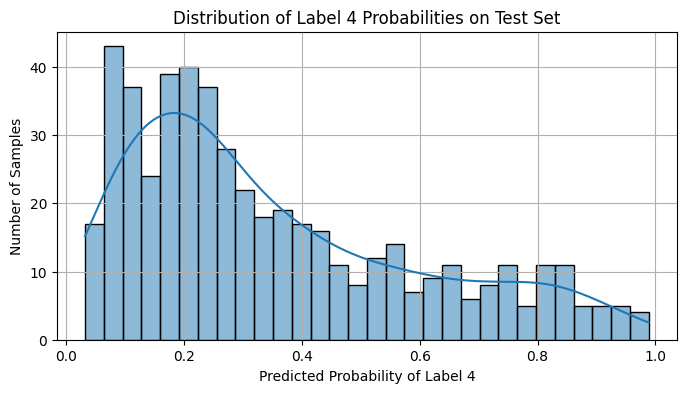

In [24]:
from torch.utils.data import Dataset, DataLoader

model = two_stage_model
class PlainTextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


test_df = pd.read_csv("./Aiffel_DLThon/data/original_data/test.csv")
test_texts = test_df["text"].tolist()

# Dataset & Dataloader
test_dataset = PlainTextDataset(test_texts, tokenizer, 200)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

import torch
from torch.nn.functional import softmax

model.eval()
label4_probs = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(model.device) for k, v in batch.items()}
        outputs = model(**batch)
        probs = softmax(outputs.logits, dim=-1)
        label4_batch_probs = probs[:, 1].cpu().numpy()
        label4_probs.extend(label4_batch_probs)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(label4_probs, bins=30, kde=True)
plt.title("Distribution of Label 4 Probabilities on Test Set")
plt.xlabel("Predicted Probability of Label 4")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

In [25]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch

def evaluate_stage1(model, dataset, batch_size=32):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size)
    preds = []
    labels = []

    for batch in tqdm(dataloader, desc="Stage 1 Evaluation"):
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)
        token_type_ids = batch["token_type_ids"].to(model.device)
        binary_labels = batch["labels"].to(model.device)

        with torch.no_grad():
            logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            ).logits  # ✅ Stage 1 logits only

        pred = torch.argmax(logits, dim=1)
        preds.extend(pred.cpu().tolist())
        labels.extend(binary_labels.cpu().tolist())

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')

    print("📊 Stage 1 Evaluation Results")
    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ F1 Score (macro): {f1:.4f}")
    print("📋 Classification Report:\n", classification_report(labels, preds, digits=4))
    return {"accuracy": acc, "f1_macro": f1}
stage1_metrics = evaluate_stage1(two_stage_model, binary_val_dataset)


Stage 1 Evaluation: 100%|██████████| 94/94 [00:13<00:00,  6.98it/s]

📊 Stage 1 Evaluation Results
✅ Accuracy: 0.9839
✅ F1 Score (macro): 0.9745
📋 Classification Report:
               precision    recall  f1-score   support

           0     0.9814    0.9987    0.9900      2371
           1     0.9947    0.9259    0.9590       607

    accuracy                         0.9839      2978
   macro avg     0.9880    0.9623    0.9745      2978
weighted avg     0.9841    0.9839    0.9837      2978



In [26]:
from collections import Counter

binary_preds = np.argmax(trainer.predict(binary_val_dataset).predictions, axis=1)
counter = Counter(binary_preds)
print("✅ Stage 1 예측 분포:", counter)

✅ compute_metrics called
🔍 type(pred.label_ids): <class 'numpy.ndarray'>
🔍 label_ids shape: (2978,)
🔍 predictions shape: (2978, 2)
✅ Stage 1 예측 분포: Counter({np.int64(0): 2413, np.int64(1): 565})


In [27]:
from torch.utils.data import DataLoader
dl = DataLoader(multi_train_dataset, batch_size=128)
all_labels = []
for batch in dl:
    lbls = batch["labels"]  # or batch[2] depending on __getitem__
    all_labels.append(lbls)
all = torch.cat(all_labels)
print("min:", all.min().item(), "max:", all.max().item())
# ==> 둘 다 0~3 사이여야 합니다.

min: 0 max: 3


In [41]:
from transformers import ElectraModel, ElectraPreTrainedModel
import torch.nn as nn

class ElectraStage2Classifier(ElectraPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.electra = ElectraModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, 4)  # 4-class

        self.init_weights()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.electra(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        cls_output = self.dropout(outputs.last_hidden_state[:, 0, :])
        logits = self.classifier(cls_output)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits
        )

class RobertaStage2Classifier(RobertaPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.roberta    = RobertaModel(config)
        self.dropout    = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(
        self,
        input_ids,
        attention_mask=None,
        token_type_ids=None,
        labels=None
    ):
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        cls_output = self.dropout(outputs.last_hidden_state[:, 0, :])
        logits     = self.classifier(cls_output)

        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss(label_smoothing=0.2)(logits, labels)

        # dict 대신 ModelOutput 반환
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions
        )


from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./stage2_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to="tensorboard",
)

"""training_args = TrainingArguments(
    output_dir='./stage2_model',
    num_train_epochs=8,
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=float(1e-6),
    weight_decay=0.1,
    warmup_ratio=0.2,
    logging_dir='./Aiffel_DLThon/logs/klue_roberta',
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    logging_strategy="steps",
    logging_steps=50,
    report_to="tensorboard",
)"""
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics_stage2(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }
from transformers import AutoConfig

config = AutoConfig.from_pretrained("klue/roberta-base", num_labels=4)
model = RobertaStage2Classifier.from_pretrained("klue/roberta-base", config=config)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=multi_train_dataset,
    eval_dataset=multi_val_dataset,
    compute_metrics=compute_metrics_stage2
)

trainer.train()


Some weights of RobertaStage2Classifier were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.798000,0.743740,0.899199,0.898923
2,0.694000,0.714037,0.935049,0.934818
3,0.629800,0.681119,0.954871,0.954993
4,0.608500,0.662317,0.964150,0.964128
5,0.597800,0.664632,0.961620,0.961394


TrainOutput(global_step=2965, training_loss=0.6842122468739296, metrics={'train_runtime': 781.1745, 'train_samples_per_second': 60.671, 'train_steps_per_second': 3.796, 'total_flos': 9742478435664000.0, 'train_loss': 0.6842122468739296, 'epoch': 5.0})

In [42]:
save_model(model, './save_model2', epoch=5)

📊 Stage 2 학습용 라벨 분포:
Label 0: 2688
Label 1: 2943
Label 2: 2937
Label 3: 3282
Label 4: 3036


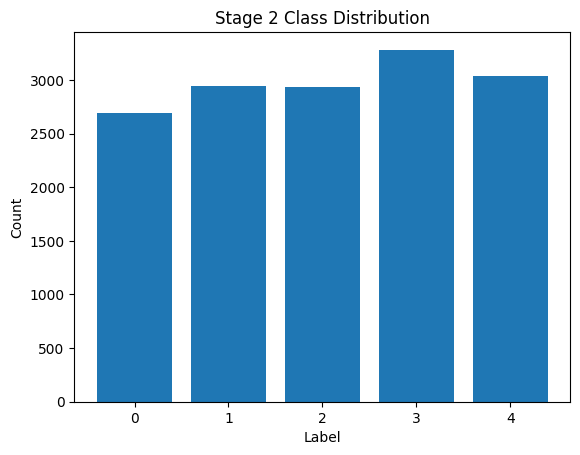

In [43]:
from collections import Counter
import matplotlib.pyplot as plt

stage2_labels = labels

# 분포 확인
label_counts = Counter(stage2_labels)

print("📊 Stage 2 학습용 라벨 분포:")
for label, count in sorted(label_counts.items()):
    print(f"Label {label}: {count}")

# 시각화
plt.bar(label_counts.keys(), label_counts.values())
plt.title("Stage 2 Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks([0, 1, 2, 3, 4])
plt.show()

In [31]:
output_dir = "./roberta_two_stage_model2"

# 디렉토리 생성 (필요시)
import os
os.makedirs(output_dir, exist_ok=True)

# 모델 저장
two_stage_model.save_pretrained(output_dir)

# config도 함께 저장
two_stage_model.config.save_pretrained(output_dir)

output_dir = "./roberta_two_stage_model1"

# 디렉토리 생성 (필요시)
import os
os.makedirs(output_dir, exist_ok=True)

# 모델 저장
model.save_pretrained(output_dir)

# config도 함께 저장
model.config.save_pretrained(output_dir)


In [44]:
def eval_stage1(model, dataloader, device):
    model.eval()
    all_preds, all_probs = [], []
    with torch.no_grad():
        for batch in dataloader:
            # batch가 dict인지 tuple/list인지 분기
            if isinstance(batch, dict):
                input_ids      = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
            else:
                # tuple/list인 경우, 첫 번째와 두 번째 요소를 사용
                input_ids      = batch[0].to(device)
                attention_mask = batch[1].to(device)

            logits = model(input_ids=input_ids,
                           attention_mask=attention_mask).logits
            probs = torch.softmax(logits, dim=-1)[:, 1]    # 협박(1) 확률
            preds = (probs >= 0.5).long()

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return np.array(all_preds), np.array(all_probs)


def eval_stage2(model, dataloader, device):
    model.eval()
    all_preds, all_probs = [], []
    with torch.no_grad():
        for batch in dataloader:
            if isinstance(batch, dict):
                input_ids      = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
            else:
                input_ids      = batch[0].to(device)
                attention_mask = batch[1].to(device)

            logits = model(input_ids=input_ids,
                           attention_mask=attention_mask).logits
            probs = torch.softmax(logits, dim=-1)
            preds = torch.argmax(probs, dim=-1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return np.array(all_preds), np.array(all_probs)


In [45]:
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import torch
from tqdm import tqdm

bin_loader = DataLoader(binary_val_dataset, batch_size=32, shuffle=False)
multi_loader = DataLoader(multi_val_dataset, batch_size=32, shuffle=False)

two_stage_model.eval()
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for b_batch, m_batch in tqdm(zip(bin_loader, multi_loader),
                                 total=len(bin_loader),
                                 desc="Val Two-Stage"):
        # Binary input & prediction
        b_input = {k: v.to(two_stage_model.device)
                   for k, v in b_batch.items()
                   if k.startswith("input_ids") or k=="attention_mask"}
        b_logits = two_stage_model(**b_input).logits
        b_preds  = torch.argmax(b_logits, dim=1)  # 0=일반, 1=위협
        b_true   = b_batch["labels"]              # 0=일반, 1=위협

        # Multi input & prediction
        m_input = {k: v.to(model.device)
                   for k, v in m_batch.items()
                   if k.startswith("input_ids") or k=="attention_mask"}
        m_logits = model(**m_input).logits         # shape (B,4)
        m_preds  = torch.argmax(m_logits, dim=1)   # 0~3
        m_true   = m_batch["labels"]               # 0~3

        # Final true & pred
        for bp, mp, bt, mt in zip(b_preds, m_preds, b_true, m_true):
            # 실제 레이블
            if bt.item() == 1:
                y_true.append(4)   # 실제 일반 → class 4
            else:
                y_true.append(mt.item())  # 실제 위협 → multiclass 0~3

            # 예측 레이블
            if bp.item() == 1:
                y_pred.append(4)   # 예측이 일반(1) → class 4
            else:
                y_pred.append(mp.item())  # 예측이 위협(0) → 0~3

# 6) classification_report 출력
#    클래스 이름은 실제 레이블 맵핑에 맞게 수정하세요.
class_names = [
    "협박 대화",
    "갈취 대화",
    "직장 내 괴롭힘 대화",
    "기타 괴롭힘 대화",
    "일반 대화"
]
print(classification_report(y_true, y_pred, target_names=class_names))

Val Two-Stage:  80%|███████▉  | 75/94 [00:21<00:05,  3.48it/s]

              precision    recall  f1-score   support

       협박 대화       0.95      0.95      0.95       442
       갈취 대화       0.93      0.96      0.94       480
 직장 내 괴롭힘 대화       0.97      0.98      0.97       474
   기타 괴롭힘 대화       0.94      0.96      0.95       510
       일반 대화       0.99      0.93      0.96       465

    accuracy                           0.95      2371
   macro avg       0.96      0.95      0.95      2371
weighted avg       0.96      0.95      0.95      2371



In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[418  12   3   7   2]
 [  9 461   3   7   0]
 [  0   3 463   8   0]
 [  4  14   1 490   1]
 [  8   6   8  12 431]]


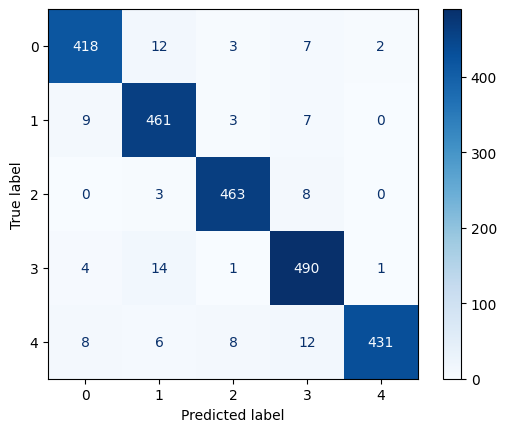

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap="Blues")

In [58]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

# Stage-1 검증 예측 확률과 실제 라벨
#  y_true : (N,) – 0(비협박) / 1(협박)
#  y_prob : (N,) – ‘협박(1)’ 클래스의 softmax 확률
def sweep_threshold(y_true, y_prob, metric="f1", step=0.02):
    best_thr, best_score = 0.5, -1
    metric_fn = {
        "f1":        f1_score,
        "precision": precision_score,
        "recall":    recall_score
    }[metric]

    for thr in np.arange(0.0, 1.0 + step, step):
        y_pred = (y_prob >= thr).astype(int)
        score  = metric_fn(y_true, y_pred)
        if score > best_score:
            best_thr, best_score = thr, score
    return best_thr, best_score

val_probs, val_labels = [], []
two_stage_model.eval()
bin_loader   = DataLoader(binary_val_dataset,
                          batch_size=32,
                          shuffle=False,)
device = next(two_stage_model.parameters()).device
for batch in bin_loader:
    enc = {k: v.to(device) for k, v in batch.items() if k != "labels"}
    with torch.no_grad():
        logits = two_stage_model(**enc).logits        # (batch, 2)
    prob_threat = torch.softmax(logits, dim=1)[:, 1]  # (batch,)
    val_probs.append(prob_threat.cpu().numpy())
    val_labels.append(batch["labels"].cpu().numpy())

val_probs   = np.concatenate(val_probs)
val_labels  = np.concatenate(val_labels)

best_thr, best_f1 = sweep_threshold(val_labels, val_probs, metric="f1")
print(f"✅ Stage-1 best F1={best_f1:.4f} @ threshold={best_thr:.3f}")

✅ Stage-1 best F1=0.9657 @ threshold=0.400


In [60]:
multi_loader = DataLoader(multi_val_dataset,
                          batch_size=32,
                          shuffle=False,)


def sweep_stage2_threshold(y_true, y_probs, reject_label=4, step=0.01):
    best_thr, best_macro_f1 = 0.0, -1
    for thr in np.arange(0.0, 1.0+step, step):
        preds = []
        for p in y_probs:
            if p.max() < thr:
                preds.append(reject_label)  # 불확실 → 특별 레이블
            else:
                preds.append(np.argmax(p))
        score = f1_score(y_true, preds, average="macro")
        if score > best_macro_f1:
            best_thr = thr
            best_macro_f1 = score
    return best_thr, best_macro_f1


s2_probs, s2_labels = [], []
model.eval()

for batch in multi_loader:
    enc = {k: v.to(model.device) for k, v in batch.items() if k != "labels"}
    with torch.no_grad():
        logits = model(**enc).logits
    probs = torch.softmax(logits, dim=1).cpu().numpy()
    s2_probs.append(probs)
    s2_labels.append(batch["labels"].cpu().numpy())

s2_probs  = np.concatenate(s2_probs, axis=0)   # (N, 4)
s2_labels = np.concatenate(s2_labels, axis=0)  # (N,)


best_thr2, best_f1_2 = sweep_stage2_threshold(s2_labels, s2_probs)
print(f"✅ Stage 2 best macro-F1 = {best_f1_2:.4f} @ threshold = {best_thr2:.3f}")

✅ Stage 2 best macro-F1 = 0.9641 @ threshold = 0.000


In [47]:
print("y_true 분포:", Counter(y_true))
print("y_pred 분포:", Counter(y_pred))

y_true 분포: Counter({3: 510, 1: 480, 2: 474, 4: 465, 0: 442})
y_pred 분포: Counter({3: 524, 1: 496, 2: 478, 0: 439, 4: 434})


In [48]:
import collections
from collections import Counter

# 1) 멀티클래스 검증 데이터셋에서 실제 labels 꺼내기
val_labels_list = [item["labels"].item() for item in multi_val_dataset]

# 2) 분포 출력
print(Counter(val_labels_list))
# 2) multi_val_dataset 의 길이 및 클래스 분포
for item in multi_val_dataset:
    print(item["labels"].item(), end=" ")

Counter({3: 643, 2: 600, 1: 585, 0: 543})
2 1 3 3 1 3 3 1 1 2 3 3 2 0 3 0 1 1 2 2 0 1 2 1 3 0 3 0 3 1 3 0 2 1 3 3 1 0 2 3 1 0 1 0 3 0 1 0 2 2 1 0 2 2 3 3 3 3 0 2 3 2 2 3 2 0 1 3 1 3 0 3 1 3 1 2 1 0 0 1 0 2 2 1 1 2 2 2 1 2 3 2 1 1 0 2 3 2 3 3 3 0 2 1 2 2 3 3 3 0 2 3 0 1 0 3 0 1 2 2 1 3 3 0 3 2 1 3 2 3 1 2 2 2 1 2 2 3 3 2 1 0 3 1 0 0 2 0 2 1 2 3 0 1 0 3 2 0 3 3 2 0 3 2 3 3 1 3 0 2 0 2 3 2 1 3 2 3 1 1 1 1 3 3 1 2 3 0 3 0 2 1 2 1 3 3 1 3 2 3 1 2 1 3 1 1 1 3 0 1 2 1 3 3 3 3 3 3 2 1 2 1 0 2 3 2 1 3 0 0 0 3 2 2 2 0 1 1 3 2 2 2 0 2 2 1 1 3 2 1 3 3 3 0 0 3 2 2 1 0 1 3 3 3 1 3 1 2 2 3 2 0 3 0 0 2 0 2 1 0 1 1 1 1 3 2 0 0 3 1 0 3 1 0 3 1 1 3 0 1 3 1 3 1 1 0 3 3 3 3 2 1 2 2 3 0 1 0 0 1 0 3 3 2 1 2 1 3 1 3 1 1 3 1 2 3 0 0 0 2 0 1 1 3 1 3 2 1 2 1 2 2 3 1 1 0 2 0 3 2 0 2 3 1 0 1 3 1 0 0 1 2 1 2 3 1 3 3 2 3 1 2 3 3 0 3 0 1 3 2 1 1 3 1 0 2 3 1 3 0 2 1 2 1 1 3 3 0 1 2 3 1 3 1 1 2 3 3 2 3 0 1 1 2 1 1 2 2 3 2 3 2 1 1 1 2 2 3 0 2 3 2 2 3 1 3 2 0 2 0 0 3 2 3 2 3 2 1 1 2 1 0 2 2 3 3 3 2 0 3 3 0 1 1 2 2 2 2 1 

## 테스트

In [65]:
from tqdm import tqdm

batch_size = 32  # 또는 16으로 줄일 수 있음
two_stage_model.eval()
model.eval()
final_preds = []
test_df = pd.read_csv("./Aiffel_DLThon/data/original_data/test.csv")
test_texts = test_df["text"].tolist()

for i in tqdm(range(0, len(test_texts), batch_size), desc="Stage 1 + Stage 2 추론"):
    batch_texts = test_texts[i:i + batch_size]

    # 인코딩 + device 이동
    batch_encodings = tokenizer(
        batch_texts,
        truncation=True,
        padding=True,
        max_length=400,
        return_tensors="pt"
    )
    batch_encodings = {k: v.to(two_stage_model.device) for k, v in batch_encodings.items()}

    with torch.no_grad():
        # Stage 1 예측
        s1_logits = two_stage_model(**batch_encodings).logits
        s1_preds = torch.argmax(s1_logits, dim=1)

        for j, s1 in enumerate(s1_preds):
            if s1 == 1:
                final_preds.append(4)
            else:
                # Stage 2 예측
                single_input = {
                    key: val[j].unsqueeze(0).to(model.device)
                    for key, val in batch_encodings.items()
                }
                with torch.no_grad():
                    s2_logits = model(**single_input).logits
                    s2_pred = torch.argmax(s2_logits, dim=1).item()
                    final_preds.append(s2_pred)

Stage 1 + Stage 2 추론: 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


In [66]:
from collections import Counter

print("📊 예측 결과 분포:")
print(Counter(final_preds))

📊 예측 결과 분포:
Counter({4: 126, 1: 104, 3: 101, 2: 95, 0: 74})


In [63]:
import torch
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm

# ─── 하이퍼파라미터 ──────────────────────────────────────────────────────────────
BATCH_SIZE          = 32
STAGE1_THRESHOLD    = 0.40        # τ = 0.400 (best F1 0.9657)

# ─── 모델 평가 모드 ─────────────────────────────────────────────────────────────
two_stage_model.eval()
model.eval()

final_preds = []
test_df     = pd.read_csv("./Aiffel_DLThon/data/original_data/test.csv")
test_texts  = test_df["text"].tolist()

for i in tqdm(range(0, len(test_texts), BATCH_SIZE), desc="Stage-1 + Stage-2 추론"):
    batch_texts = test_texts[i : i + BATCH_SIZE]

    # ── 토큰화 & 디바이스 이동 ────────────────────────────────────────────────
    batch_enc = tokenizer(
        batch_texts,
        truncation=True,
        padding=True,
        max_length=400,
        return_tensors="pt"
    )
    batch_enc = {k: v.to(two_stage_model.device) for k, v in batch_enc.items()}

    with torch.no_grad():
        # ── Stage-1: 유해 확률 계산 ───────────────────────────────────────────
        s1_logits       = two_stage_model(**batch_enc).logits          # (B,2)
        probs_harmful   = F.softmax(s1_logits, dim=1)[:, 0]            # 클래스 0 = 유해
        harm_mask       = probs_harmful >= STAGE1_THRESHOLD            # True → Stage-2 대상

        # ── 기본 예측 = 전부 일반(4)로 초기화 ────────────────────────────────
        batch_preds = torch.full_like(probs_harmful, fill_value=4, dtype=torch.long)

        if harm_mask.any():
            # ── Stage-2: 멀티클래스(0~3) 추론 ──────────────────────────────
            harm_inputs = {k: v[harm_mask] for k, v in batch_enc.items()}
            s2_logits   = model(**harm_inputs).logits                   # (H,4)
            s2_preds    = torch.argmax(s2_logits, dim=1)                # 0~3

            # ── 유해 위치에 Stage-2 결과 삽입 ───────────────────────────────
            batch_preds[harm_mask] = s2_preds

    final_preds.extend(batch_preds.tolist())

# final_preds 에 최종 0~4 라벨 완성


Stage-1 + Stage-2 추론: 100%|██████████| 16/16 [00:02<00:00,  5.37it/s]


In [64]:
from collections import Counter

print("📊 예측 결과 분포:")
print(Counter(final_preds))

📊 예측 결과 분포:
Counter({3: 115, 1: 109, 2: 105, 4: 92, 0: 79})


In [67]:
id_to_label = {
    0: "협박 대화",
    1: "갈취 대화",
    2: "직장 내 괴롭힘 대화",
    3: "기타 괴롭힘 대화",
    4: "일반 대화"
}
for i in range(500):
    print(f"문장: {test_texts[i]}")
    print(f"예측 라벨: {id_to_label[final_preds[i]]}")
    print("-" * 30)

문장: 아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나보네 그럼 취소할까요 아가씨 내 여기단골이니 담에 갖다줄께 저도 알바생이라 외상안됩니다 아따 누가 떼먹는다고 그러나 갖다준다고 안됩니다 자꾸이럼 경찰불러요 아가씨 담배피는교 그건 왜 물으세요 그람 아가씨 담배 한대만 빌립시다 내 지금 지갑도 잃어버리고 기분이 그래서 그러니 여기요  아따 주는김에 한개더 주면 되겠네
예측 라벨: 일반 대화
------------------------------
문장: 우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때?  네? 제가요? 그렇지? 2달만 파견 잘 갔다오면 승진이야. 네? 저는 별로 가고 싶지 않습니다. 여기 있는 모든사람도 가기 싫어해. 그러니까 막내인 영지씨가 가는게 맞지 정말 죄송합니다. 저는 못갑니다. 장난해? 모두를 위해 영지씨가 희생하는게 싫어? 네. 부당한 방법으로 가는 것 같습니다. 영지씨 안가면 회사생활 오래 못할 것 같은데 그래도 안갈거야? 안가면 지옥일텐데. 그래도 이 방법은 아닌 것 같습니다. 죄송합니다.
예측 라벨: 직장 내 괴롭힘 대화
------------------------------
문장: 너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 행실이 맘에 안들어 네 실천할께요 옆에 동기들 좀 본받으란 말야 어? 네 알겠습니다 그래 똑바로해 노럭할께요
예측 라벨: 직장 내 괴롭힘 대화
------------------------------
문장: 이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 요즘 듣는 것도 들어봐 음 난 좀 별론데 좋을 줄 알았는데 아쉽네 내 취향은 아닌 듯 배고프다 밥이나 먹으러 가자 그래
예측 라벨: 일반 대화
------------------------------
문장: 아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도 말해야지? .켰습니다. 주인님. 오냐. 앞으로도

In [39]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd

#— 하이퍼파라미터: 상황에 맞게 조정하세요 —#
batch_size     = 32
prob_threshold = 0.6   # max softmax 확률 임계값
std_threshold  = 0.45   # softmax 분포 표준편차 임계값
max_length     = 400

two_stage_model.eval()
model.eval()

final_preds = []
test_df     = pd.read_csv("./Aiffel_DLThon/data/original_data/test.csv")
test_texts  = test_df["text"].tolist()

for i in tqdm(range(0, len(test_texts), batch_size), desc="Stage 1 + Stage 2 추론"):
    batch_texts    = test_texts[i:i + batch_size]
    batch_encodings = tokenizer(
        batch_texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt"
    )
    # device에 올리기
    batch_encodings = {k: v.to(two_stage_model.device) for k, v in batch_encodings.items()}

    with torch.no_grad():
        # — Stage 1 예측 — #
        s1_logits = two_stage_model(**batch_encodings).logits
        s1_preds  = torch.argmax(s1_logits, dim=1)

        for j, s1 in enumerate(s1_preds.tolist()):
            if s1 == 1:
                # Stage 1에서 협박으로 판정 → 바로 label 4
                final_preds.append(4)
            else:
                # — Stage 2 예측 — #
                single_input = {
                    key: val[j].unsqueeze(0).to(model.device)
                    for key, val in batch_encodings.items()
                }
                with torch.no_grad():
                    s2_logits = model(**single_input).logits  # shape: [1, num_labels]
                    probs     = F.softmax(s2_logits, dim=-1).squeeze(0)  # shape: [num_labels]

                max_prob = probs.max().item()
                std_prob = probs.std().item()

                # 임계값 미만이면 label 4, 아니면 예측값
                if (max_prob < prob_threshold) or (std_prob < std_threshold):
                    final_preds.append(4)
                else:
                    final_preds.append(probs.argmax().item())

# 결과를 DataFrame에 붙여서 저장 예시
test_df["pred_label"] = final_preds
test_df.to_csv("./Aiffel_DLThon/data/submission_with_threshold.csv", index=False)
print("✅ 임계값 기반 라벨링 완료, 파일 저장됨.")


Stage 1 + Stage 2 추론: 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]


✅ 임계값 기반 라벨링 완료, 파일 저장됨.


In [40]:
from collections import Counter

print("📊 예측 결과 분포:")
print(Counter(final_preds))

📊 예측 결과 분포:
Counter({4: 500})


In [49]:
id_to_label = {
    0: "협박 대화",
    1: "갈취 대화",
    2: "직장 내 괴롭힘 대화",
    3: "기타 괴롭힘 대화",
    4: "일반 대화"
}
for i in range(500):
    print(f"문장: {test_texts[i]}")
    print(f"예측 라벨: {id_to_label[final_preds[i]]}")
    print("-" * 30)

문장: 아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나보네 그럼 취소할까요 아가씨 내 여기단골이니 담에 갖다줄께 저도 알바생이라 외상안됩니다 아따 누가 떼먹는다고 그러나 갖다준다고 안됩니다 자꾸이럼 경찰불러요 아가씨 담배피는교 그건 왜 물으세요 그람 아가씨 담배 한대만 빌립시다 내 지금 지갑도 잃어버리고 기분이 그래서 그러니 여기요  아따 주는김에 한개더 주면 되겠네
예측 라벨: 일반 대화
------------------------------
문장: 우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때?  네? 제가요? 그렇지? 2달만 파견 잘 갔다오면 승진이야. 네? 저는 별로 가고 싶지 않습니다. 여기 있는 모든사람도 가기 싫어해. 그러니까 막내인 영지씨가 가는게 맞지 정말 죄송합니다. 저는 못갑니다. 장난해? 모두를 위해 영지씨가 희생하는게 싫어? 네. 부당한 방법으로 가는 것 같습니다. 영지씨 안가면 회사생활 오래 못할 것 같은데 그래도 안갈거야? 안가면 지옥일텐데. 그래도 이 방법은 아닌 것 같습니다. 죄송합니다.
예측 라벨: 직장 내 괴롭힘 대화
------------------------------
문장: 너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 행실이 맘에 안들어 네 실천할께요 옆에 동기들 좀 본받으란 말야 어? 네 알겠습니다 그래 똑바로해 노럭할께요
예측 라벨: 직장 내 괴롭힘 대화
------------------------------
문장: 이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 요즘 듣는 것도 들어봐 음 난 좀 별론데 좋을 줄 알았는데 아쉽네 내 취향은 아닌 듯 배고프다 밥이나 먹으러 가자 그래
예측 라벨: 일반 대화
------------------------------
문장: 아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도 말해야지? .켰습니다. 주인님. 오냐. 앞으로도

In [101]:
# 1. 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# 2. 입력 텐서도 같은 디바이스로 이동
data_config = {
    "test_file": "/content/Aiffel_DLThon/data/processed/clean_test.csv",
    "train_file": "./Aiffel_DLThon/data/processed/original/clean_train.csv"
}

# ✅ 올바른 접근
test_df = pd.read_csv(data_config["test_file"])
test_encodings = tokenizer(
    test_df["clean_text"].tolist(),
    padding="max_length",
    truncation=True,
    max_length=400,
    return_tensors="pt"
)

# ⬇️ 여기가 핵심
test_encodings = {k: v.to(device) for k, v in test_encodings.items()}

# 3. 예측
with torch.no_grad():
    outputs = model(**test_encodings)
    preds = outputs.logits.argmax(dim=-1).cpu().numpy()

In [68]:
save_submission(final_preds, "./Aiffel_DLThon/data/original_data/submission.csv", './submission.csv')
log_message("Experiment complete.", '.')

[2025-05-06 21:21:50] Experiment complete.


In [69]:
# 파일 로딩
df = pd.read_csv('/content/submission.csv')
log_target_distribution(df, '.')

[2025-05-06 21:22:01] 📊 Target 클래스 분포:
[2025-05-06 21:22:01] Label 0: 74
[2025-05-06 21:22:01] Label 1: 104
[2025-05-06 21:22:01] Label 2: 95
[2025-05-06 21:22:01] Label 3: 101
[2025-05-06 21:22:01] Label 4: 126
